In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
MODEL_FOLDER = "./stat_models/"

In [3]:
!rm -rf $MODEL_FOLDER
!mkdir $MODEL_FOLDER

In [4]:
def previous_window_impute(station_df, window_length=14):
    column = "PM2.5"
    try:
        for idx, value in enumerate(station_df[column].values):
            if np.isnan(value):
                station_df[column][idx] = station_df[column][idx - window_length]
    except:
        pass
    return station_df

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import warnings
warnings.filterwarnings('ignore')

In [6]:
def get_AR_model(training_set, test_set, days):
    
    predictions = np.array([])

    for i in range(0, days):
        model = AutoReg(training_set, lags=5)
        model_fit = model.fit()        
        prediction = model_fit.predict(start=len(training_set), end=len(training_set))
        predictions = np.append(predictions, prediction)
        training_set = np.append(training_set, test_set[i])
        
    score = {
        "r2_score": r2_score(test_set, predictions),
        "mae": mean_absolute_error(test_set, predictions), 
        "rmse": np.sqrt(mean_squared_error(test_set, predictions)),
        "mean": np.mean(test_set)
    }

    return model_fit, score, None, predictions 

def get_ARIMA_model(training_set, test_set, days):
    
    predictions = np.array([])

    for i in range(0, days):
        model = SARIMAX(training_set, order=(1,1,1))
        model_fit = model.fit()        
        prediction = model_fit.predict(start=len(training_set), end=len(training_set))
        predictions = np.append(predictions, prediction)
        training_set = np.append(training_set, test_set[i])
        
    score = {
        "r2_score": r2_score(test_set, predictions),
        "mae": mean_absolute_error(test_set, predictions), 
        "rmse": np.sqrt(mean_squared_error(test_set, predictions)),
        "mean": np.mean(test_set)
    }

    return model_fit, score, None, predictions 

def get_HoltWinters_model(training_set, test_set, days):       
    
    t,d,s,p,b,r = 'add', False, 'mul', 7, False, False
    predictions = np.array([])

    for i in range(0, days):
        model = ExponentialSmoothing(training_set, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)        
        prediction = model_fit.predict(start=len(training_set), end=len(training_set))
        predictions = np.append(predictions, prediction)
        training_set = np.append(training_set, test_set[i])
        
    score = {
        "r2_score": r2_score(test_set, predictions),
        "mae": mean_absolute_error(test_set, predictions), 
        "rmse": np.sqrt(mean_squared_error(test_set, predictions)),
        "mean": np.mean(test_set)
    }

    return model_fit, score, None, predictions

In [7]:
MODEL_LIST = [
    ('AR', get_AR_model),
    ('ARIMA', get_ARIMA_model),
    ('Holt-Winters', get_HoltWinters_model)
]

In [8]:
plt.rc('text', usetex=True)  
plt.rc('font', family='sans-serif')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def line_format(label):
    if (label.day % 15 == 0):
        return f"{label.day}\n{label.month_name()[:3]}"

def perform_modelling(station_data, training_set, test_set, test_idx_values, 
                      days, station_id, dataset_name, show_graph=True):

    best = {}
    best_score = 9e9

    rows = []

    predictions = {}
    predictions['Actual'] = test_set.reshape(-1)

    for name, model_fn in MODEL_LIST:
        details = {}
        regressor, score, scaler, y_pred = model_fn(training_set, test_set, days)
        row = [f"{name}", score['mae'], score['rmse'], score['r2_score'], score['mean']]
        rows.append(row)

        predictions[name + ""] = y_pred.reshape(-1)
        
        details['station_name'] = station_data[0]
        details['station_id'] = station_id
        details['name'] = name + ""
        details['regressor'] = regressor
        details['scaler'] = scaler
        details['score'] = score       
        details['test_set_predictions'] = y_pred
        details['test_set'] = test_set
        
        with open(MODEL_FOLDER + f"{dataset_name}/{name}/{station_id}_pm25.pkl", "wb") as file:
            pickle.dump(details, file, protocol=4)

        if score['rmse'] < best_score:
            best = details
            best_score = score['rmse']

    model_dfs = pd.DataFrame(rows, columns=["model", "mae", "rmse", "r2_score", "mean"])
    
    test_idx_values += datetime.timedelta(days=1)
    predictions_df = pd.DataFrame(predictions, index=test_idx_values)
    predictions_df.to_pickle(MODEL_FOLDER + f"{dataset_name}/{station_id}_predictions.pkl")
   
    if show_graph:
        fig = plt.figure(figsize=(18, 4))
        ax = fig.gca()
        
        predictions_df[['Actual', best['name']]].plot(ax=fig.gca())
        plt.title(f"{station_id} | Test Set", fontsize=14)
        plt.ylabel('PM2.5')
#         plt.grid(ls='--')
        
        msg_rmse = f"RMSE: {best['score']['rmse'].round(3)}"
        msg_mae =  f"MAE:  {best['score']['mae'].round(3)}"
        msg_mean = f"MEAN: {best['score']['mean'].round(3)}"
        
        msg = msg_rmse + '\n' + msg_mae + '\n' + msg_mean 
        
        ax.set_xticks(predictions_df.index)
        ax.set_xticklabels(map(line_format, predictions_df.index), rotation=0,  ha="center");
        
        ax.text(0.475, 0.85, msg,
             bbox=dict(facecolor='white', alpha=1),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=12,
             transform=ax.transAxes)

    return best, model_dfs, predictions_df, ax  

In [9]:
import multiprocessing as mp

manager = mp.Manager()
ax_list = manager.list()

def perform_task(idx, dataset, dataset_name):
    
    station_dict = dataset[idx]
    station_df = station_dict['df']
    station_data = [station_dict[key] for key in list(station_dict.keys())[:-1]]
    
    try:

        station_df.index.freq = 'D'
        station_pm25_df = pd.DataFrame(station_df['PM2.5'])

        reframed_df = station_pm25_df
        ratio = 0.3

        length = len(reframed_df)
        limit = (int)(ratio * length)

        training_set, test_set = reframed_df.values[:-limit], reframed_df.values[-limit:]
        test_idx_values = reframed_df.index.to_pydatetime()[-limit:]
        days = len(test_idx_values)

        best, model_dfs, predictions_df, ax = perform_modelling(station_data, training_set, test_set, test_idx_values, days, station_data[1], dataset_name, show_graph=True)

        ax_list.append(ax)
        
    except Exception as e:
        print(f"Error at : {station_dict['station_id']}, {station_dict['station_name']} - {e}")

#     with open(MODEL_FOLDER + f"{station_id}_pm25.pkl", "wb") as file:
#         pickle.dump(best, file, protocol=4)

In [10]:
import os

POLLUTANT = "PM2.5"
datasets = [
            "delhi", 
            "seoul", 
            "skopje", 
            "ulaanbaatar"
           ]

pool = mp.Pool(mp.cpu_count())

for dataset_name in datasets:

    try:
        os.mkdir(MODEL_FOLDER + dataset_name)               
    except:
        pass
    
    dataset = pickle.load(open(f"./Data/{dataset_name}_dataset.pkl", "rb"))
    
    try:
        for name, model_fn in MODEL_LIST:
            os.mkdir(MODEL_FOLDER + f"{dataset_name}/{name}")
    except:
        pass

    pool.starmap(perform_task, [(idx, dataset, dataset_name) for idx in range(len(dataset))])
    
pool.close()

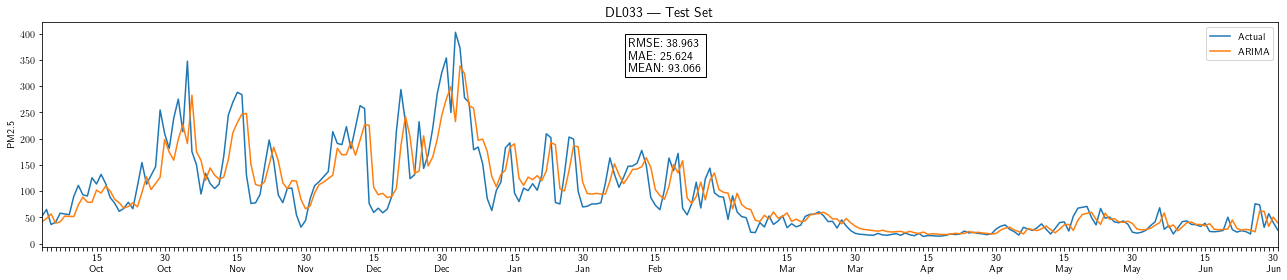

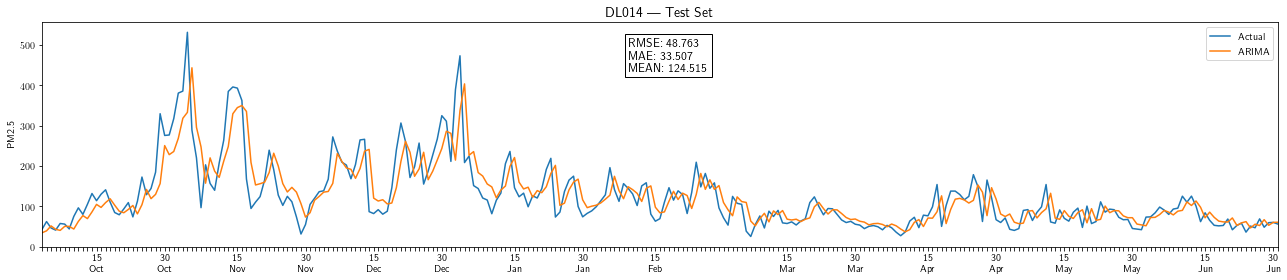

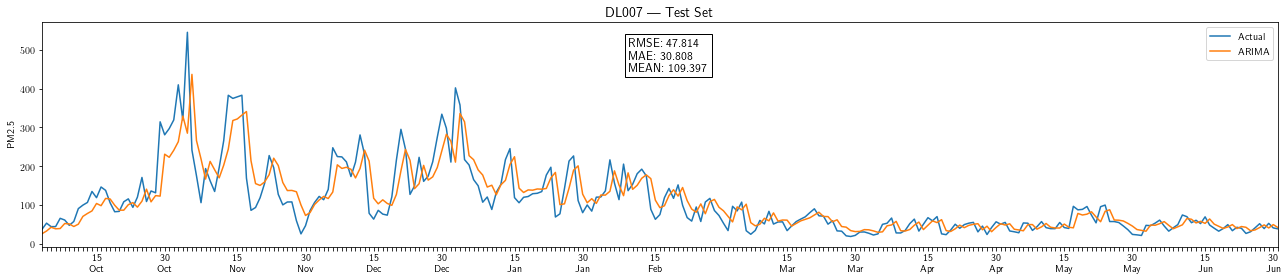

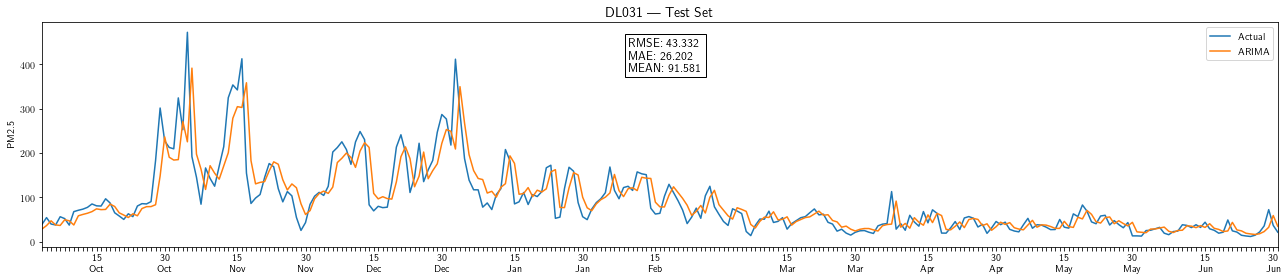

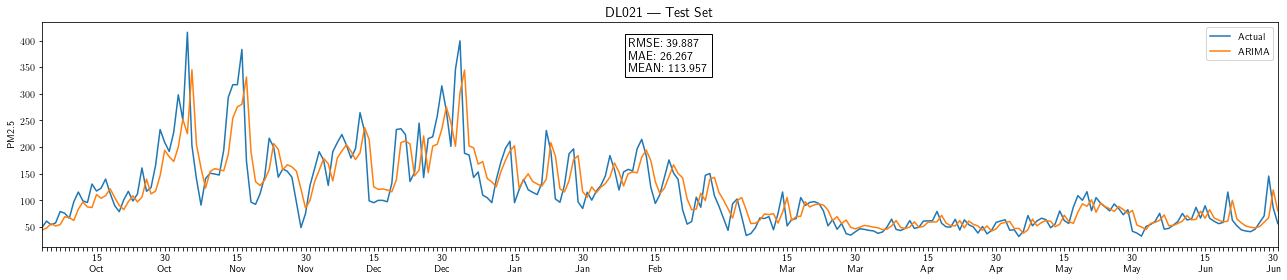

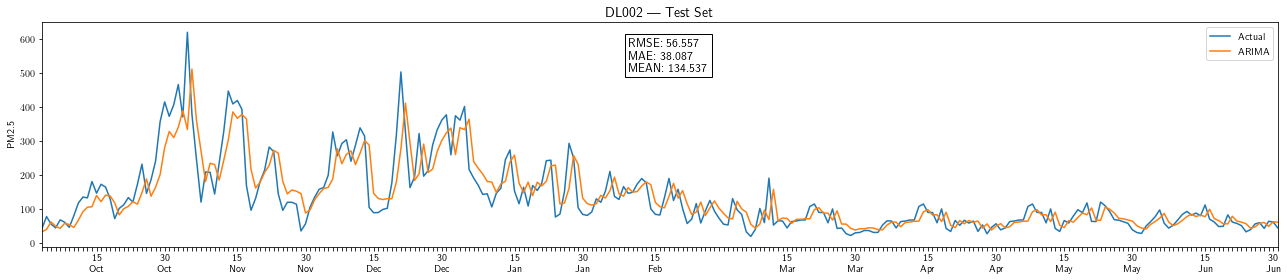

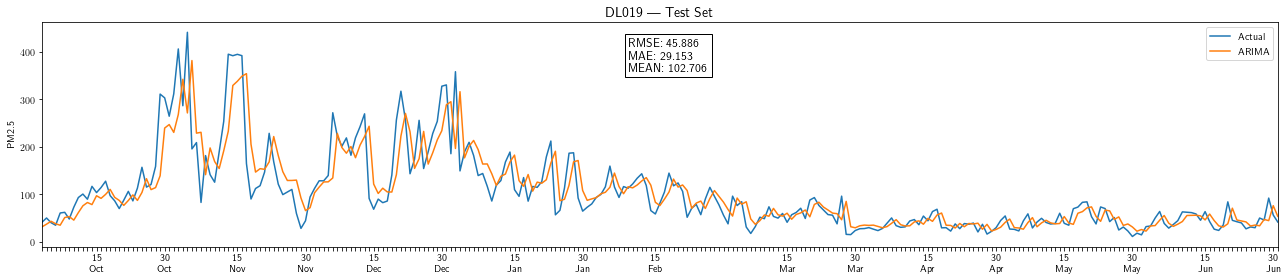

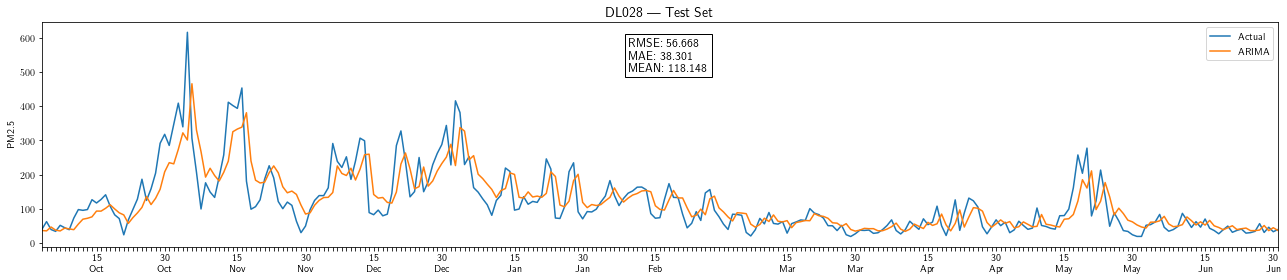

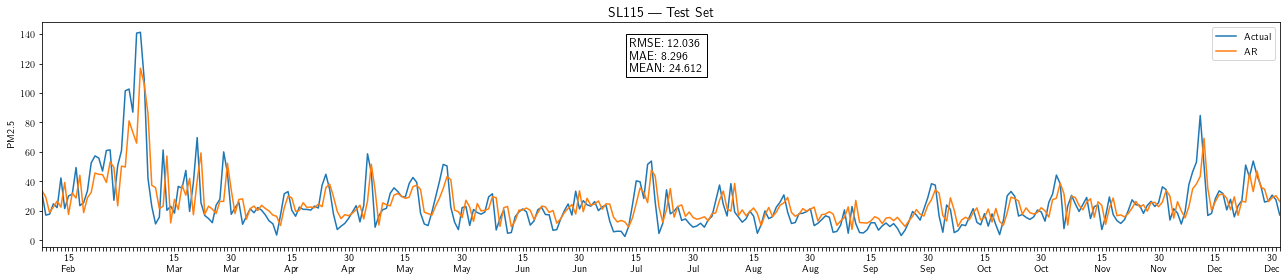

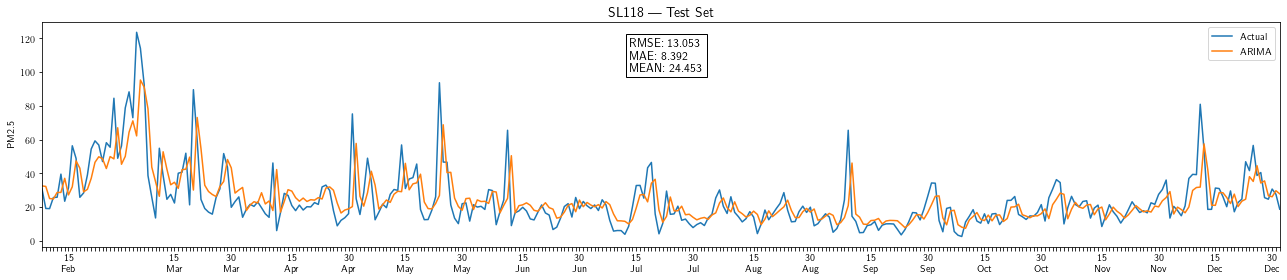

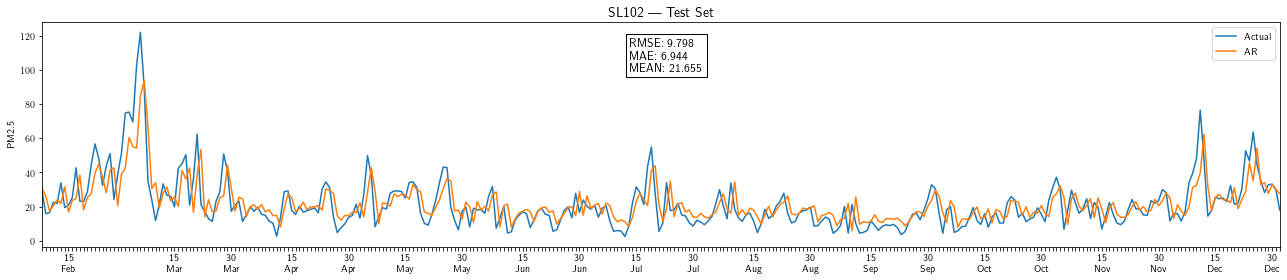

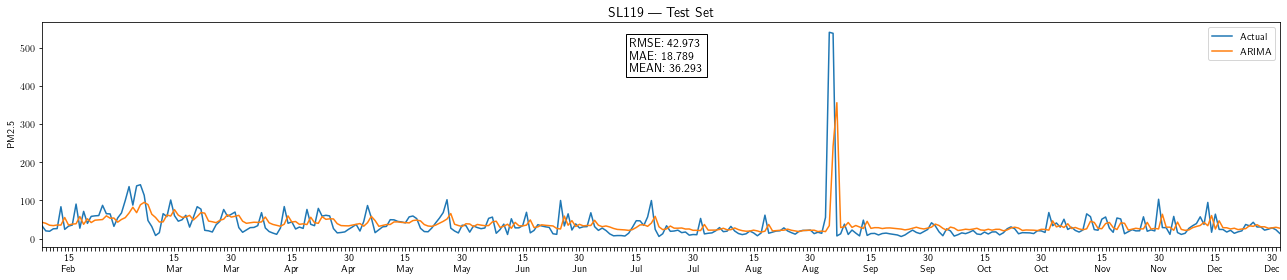

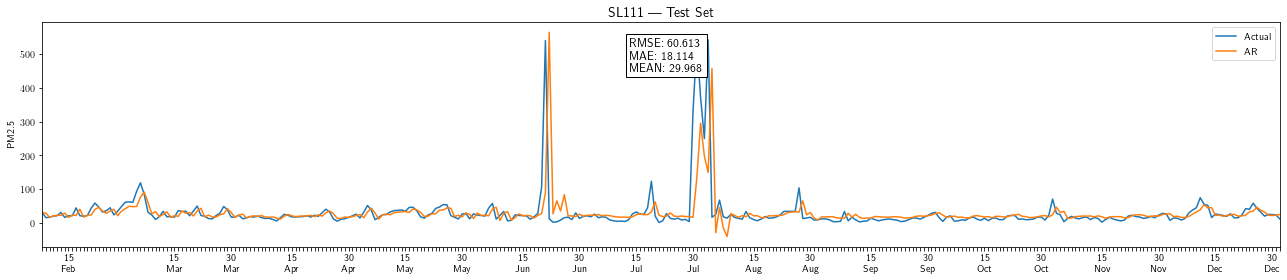

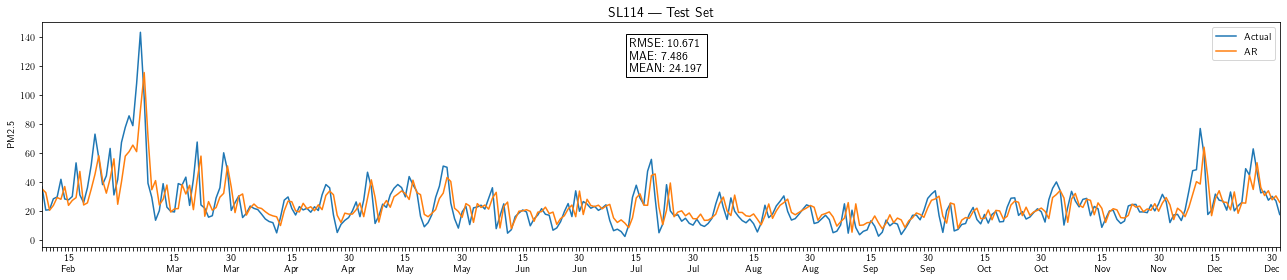

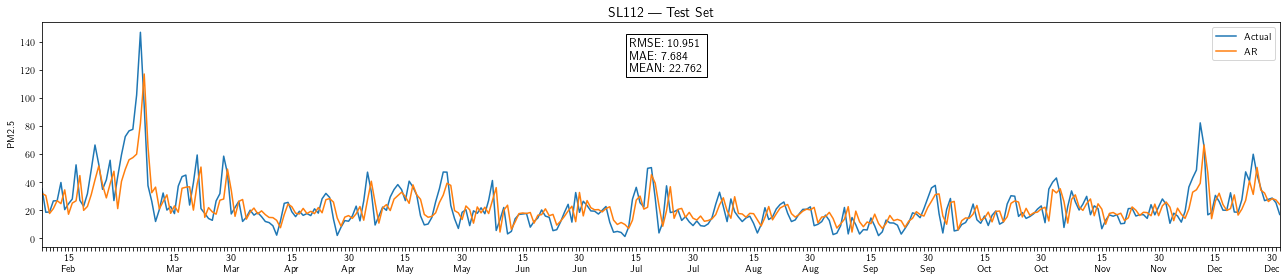

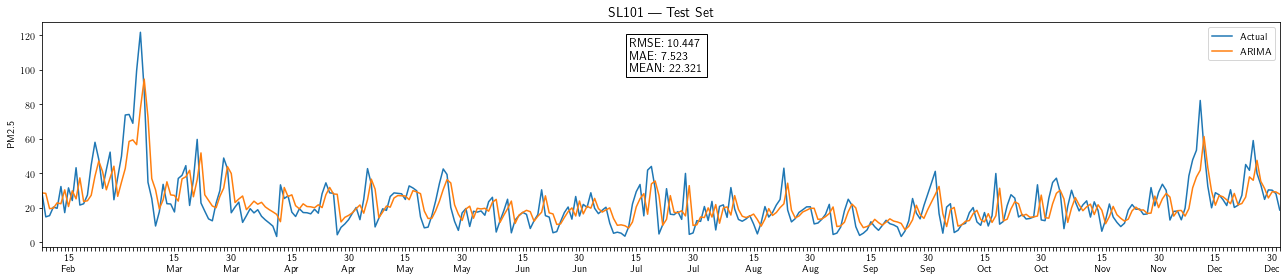

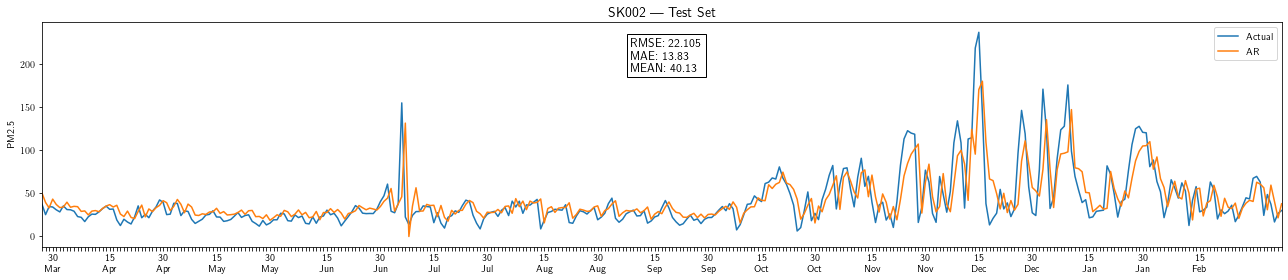

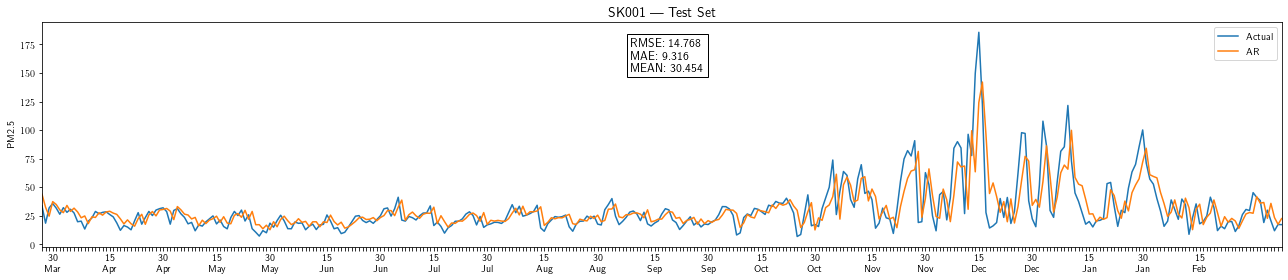

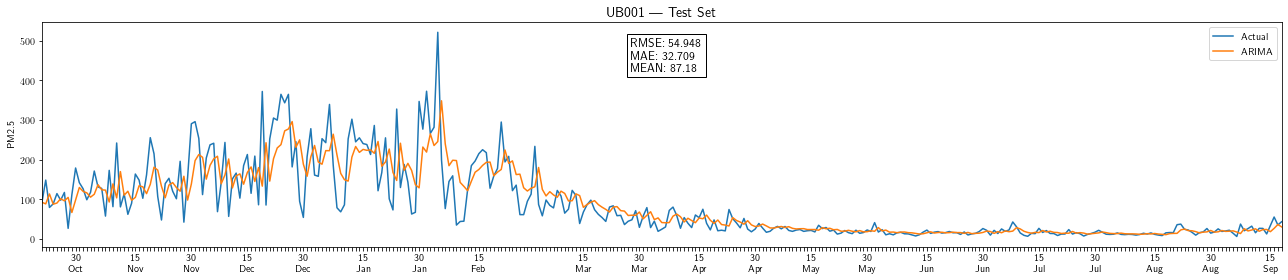

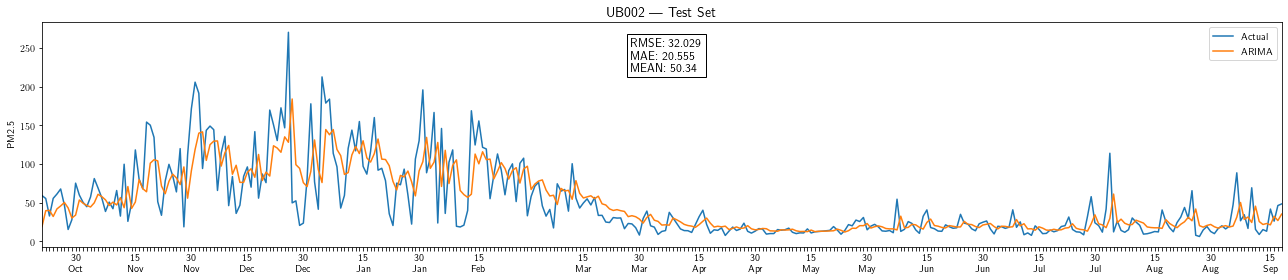

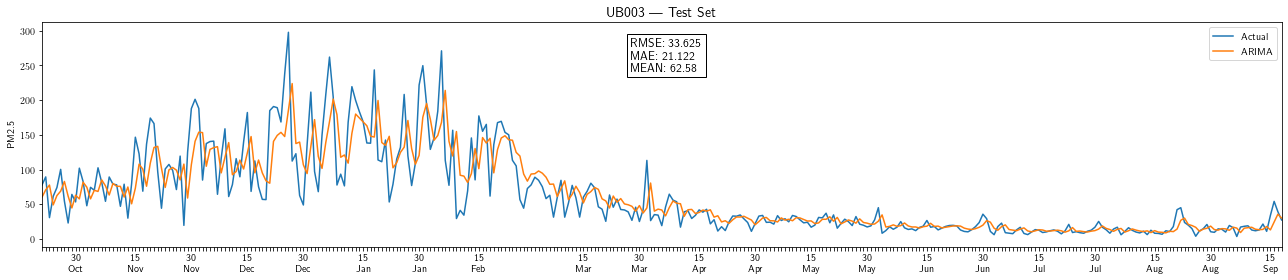

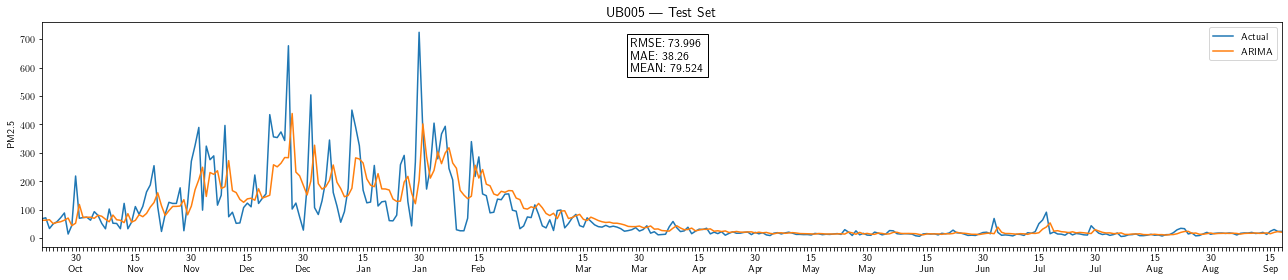

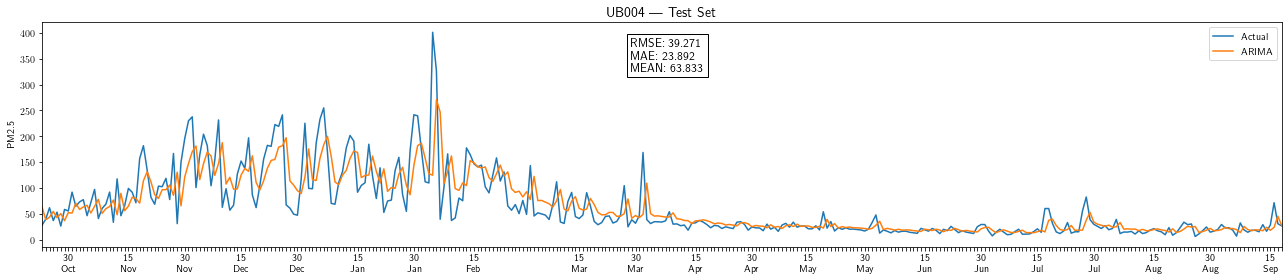

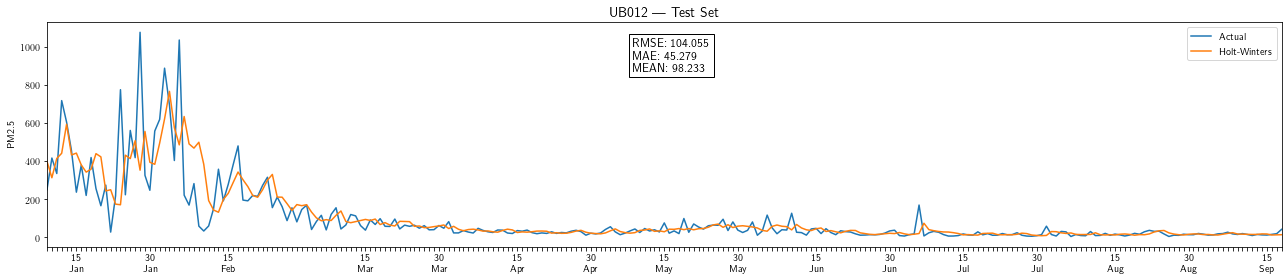

In [11]:
for ax in ax_list:
    plt.show()